# Exercises with Azure ML Services using ython Notebooks

loading the data sets

In [1]:
import os
import urllib.request

#create a folder for the dataset
os.makedirs('./data', exist_ok = True)

# load dataset to the directory--as you can see, you must load train sets and test sets separately
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename='./data/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename='./data/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./data/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./data/test-labels.gz')

('./data/test-labels.gz', <http.client.HTTPMessage at 0x7ff9acae7c88>)

In [2]:
import gzip
import numpy as np
import struct

# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res

print('Functions defined')

Functions defined


In [3]:
# To help the model converge faster, shrink the intensity values (X) from 0-255 to 0-1

X_train = load_data('./data/train-images.gz', False) / 255.0
y_train = load_data('./data/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/test-images.gz', False) / 255.0
y_test = load_data('./data/test-labels.gz', True).reshape(-1)

print('Data loaded')

Data loaded


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


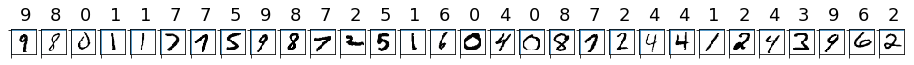

Done


In [4]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np


count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
    
plt.show()

print('Done')

#  Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression

#load the model
clf = LogisticRegression(multi_class='multinomial',  solver='newton-cg')
#fit the model
clf.fit(X_train, y_train)

#evaluate the model by using a test set
y_hat = clf.predict(X_test)
#print the accuracy
print(np.average(y_hat == y_test))

print('Done')

0.9256
Done


In [10]:
print(y_hat)

[7 2 1 ... 4 5 6]


# Create an "Experiment"

In [32]:
# crear el workspace desde cero
from azureml.core import Workspace,Experiment,Run

#ws = Workspace.create(
            name='',
            subscription_id='', 
            resource_group='',
            create_resource_group=False,
            location=''
)

SyntaxError: invalid syntax (<ipython-input-32-91d0433e426d>, line 10)

In [ ]:
# si el workspace se crea desde el portal solo es llamar al workspace 
# el workspace se crea como un recurso "Machine Learing service workspace"
from azureml.core import Workspace,Experiment,Run

ws = Workspace.get(name='',
            subscription_id='', 
            resource_group='')
print(ws)

In [15]:
from azureml.core import Experiment
#Create an experiment
experiment = Experiment(workspace = ws, name = "my-first-experiment")

#Create a run
run = experiment.start_logging()
run.log("trial",1)
run.complete()

View the logged results

In [16]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

You can view the experiment run in the Azure portal. To print a URL that links to the results for the last run, use the following code:

In [ ]:
print(run.get_portal_url())

# Train a model using the Experimentation Service

You learned that a compute target is the compute resource to run a training script or to host a service deployment. Here you will create an Azure Machine Learning Compute (AmlCompute) as the compute resource. An AmlCompute is a compute target optimized for machine learning workloads that's managed directly by Azure Machine Learning service. You don't need to connect or configure these targets - the system takes care of them for you.

The first step is to create a remote compute target:

In [18]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# Step 1: name the cluster and set the minimal and maximal number of nodes 
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpucluster")
min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 3)

# Step 2: choose environment variables 
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")

provisioning_config = AmlCompute.provisioning_configuration(
    vm_size = vm_size, min_nodes = min_nodes, max_nodes = max_nodes)

# create the cluster
compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)

print('Compute target created')

Compute target created


# Load data and create a modeling script


In [19]:
#upload data by using get_default_datastore()
ds = ws.get_default_datastore()
ds.upload(src_dir='./data', target_path='mnist', overwrite=True, show_progress=True)

print('Done')

Uploading an estimated of 4 files
Uploading ./data/test-images.gz
Uploading ./data/test-labels.gz
Uploading ./data/train-images.gz
Uploading ./data/train-labels.gz
Uploaded ./data/test-labels.gz, 1 files out of an estimated total of 4
Uploaded ./data/train-labels.gz, 2 files out of an estimated total of 4
Uploaded ./data/test-images.gz, 3 files out of an estimated total of 4
Uploaded ./data/train-images.gz, 4 files out of an estimated total of 4
Uploaded 4 files
Done


In [20]:
# Then you create a directory to save your training Python code:
import os

# create the folder
folder_training_script = './trial_model_mnist'
os.makedirs(folder_training_script, exist_ok=True)

print('Done')

Done


Finally, let's prepare our model training script (note that in this script, you are defining two parameters):

The first parameter is for finding the data in the cloud or for setting the path to the data.
The other parameter is the regularization parameter in the algorithm.

In [29]:
%%writefile $folder_training_script/train.py

import argparse
import os
import numpy as np
import glob

from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

from azureml.core import Run
# from utils import load_data

import gzip
import struct

# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


# let user feed in 2 parameters, the dataset to mount or download, and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

###
data_folder = os.path.join(args.data_folder, 'mnist')
print('Data folder:', data_folder)

# load the train and test set into numpy arrays
X_train = load_data(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0

#print variable set dimension
print(X_train.shape, X_test.shape, sep = '\n')

y_train = load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)

#print the response variable dimension
print( y_train.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularization rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, solver="liblinear", multi_class="auto", random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

Overwriting ./trial_model_mnist/train.py


In [31]:
from sklearn.externals import joblib
os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

['outputs/sklearn_mnist_model.pkl']

Notice that the last line of the training script saves the model as a pickle file in the outputs folder of the experiment workspace. You use this pickle file later to deploy the model.

An estimator object is used to submit the run. Create your estimator by running the following code to define:

#*The name of the estimator object, est.
#*The directory that contains your scripts. All the files in this directory are uploaded into the cluster nodes for running.
#*The compute target. In this case, you use the Azure Machine Learning compute cluster that you created.
#*The training script name, train.py.
#*Parameters that the training script requires.
#*Python packages that are necessary for training.


In [23]:
from azureml.train.sklearn import SKLearn

script_params = {
    '--data-folder': ds.as_mount(),
    '--regularization': 0.5
}

#import the Scikit-learn package 
est = SKLearn(source_directory=folder_training_script,
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py',
                conda_packages=['scikit-learn'])

WARNING - You have specified to install packages in your run. Note that you have overridden Azure ML's installation of the following packages: ['scikit-learn']. We cannot guarantee image build will succeed.


# Submit the model, monitor the run, and retrieve the results
We need to create an Experiment to run the model training in.

In [24]:
from azureml.core import Experiment

#Create an experiment
experiment = Experiment(workspace = ws, name = "amls-learn-experimentnew5")

print('Experiment created')

Experiment created


The last step is running the model. Sign in with your Azure account if prompted to do so.

In [25]:
run = experiment.submit(config=est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
amls-learn-experimentnew5,amls-learn-experimentnew5_1574352469_be530c50,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


You could use the widgets module from the azureml package to monitor your run:

In [27]:
# monitor the run
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

After this run finishes, you can print the results. The results were logged because you wrote the code in the training script.

In [28]:
#get the result
print(run.get_metrics())

{}
